# MNIST Handwriten Digits Classifier

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
model_root_dir = '/notebooks/my-notebooks/MNIST/'

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(model_root_dir+'MNIST_data', one_hot=True)

Extracting /notebooks/my-notebooks/MNIST/MNIST_data/train-images-idx3-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
image_size = 28
num_classes = 10
embedding_size = 10

In [4]:
batch_size = 100
learning_rate = 0.5

epochs = 2
iterations = mnist.train.num_examples//batch_size

In [5]:
model_logdir = model_root_dir+'logdir/'

LABELS = os.path.join(os.getcwd(), model_logdir+"labels_1024.tsv")
SPRITES = os.path.join(os.getcwd(), model_logdir+"sprite_1024.png")

hparam_str = 'fc1,lr_%f' % (learning_rate)
previous_runs = list(f for f in os.listdir(model_logdir) if f.startswith('run'))

if len(previous_runs) == 0:
    run_number = 1  
else:
    run_number = max([int(s[4:6]) for s in previous_runs]) + 1

LOGDIR = '%srun_%02d,' % (model_logdir, run_number)+hparam_str

In [6]:
tf.reset_default_graph()

In [7]:
with tf.name_scope('input'):
    X_placeholder = tf.placeholder(shape=[None, image_size**2], dtype=tf.float32, name='X_placeholder')
    Y_placeholder = tf.placeholder(shape=[None, num_classes], dtype=tf.int64, name='Y_placeholder')

with tf.name_scope('input_reshaped'):
    X_image = tf.reshape(X_placeholder, shape=[-1,image_size,image_size, 1])
    tf.summary.image('input', X_image, 3)

In [8]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [9]:
with tf.name_scope('output_layer'):
    
    with tf.name_scope('Weights'):
        W = tf.Variable(tf.zeros(shape=[image_size**2, num_classes]), dtype=tf.float32, name='W')
        variable_summaries(W)
        
        with tf.name_scope('visualize_weights'):
            W_image = tf.reshape(tf.transpose(W,perm=[1,0]),[-1,image_size,image_size,1])
            tf.summary.image("visualize_weights", W_image, max_outputs=num_classes)
        
    with tf.name_scope('biases'):
        b = tf.Variable(tf.constant(0.1,shape=[num_classes]), dtype=tf.float32, name='b')
        variable_summaries(b)
        
    with tf.name_scope('predictions'):
        Y_predictions = tf.matmul(X_placeholder, W) + b
        
    embedding_input = Y_predictions

In [10]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_placeholder,
                                                               logits=Y_predictions,
                                                               name='cross_entropy')
    
    loss = tf.reduce_mean(cross_entropy)
    tf.summary.scalar('loss', loss)

with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [11]:
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_predictions'):
        correct_prediction = tf.equal(tf.argmax(Y_predictions, 1), tf.argmax(Y_placeholder, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

In [12]:
sess = tf.InteractiveSession()

In [13]:
summ = tf.summary.merge_all()

embedding = tf.Variable(tf.zeros([1024, embedding_size]), name="embedding")
assignment = embedding.assign(embedding_input)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter(LOGDIR)
writer.add_graph(sess.graph)

config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
embedding_config = config.embeddings.add()
embedding_config.tensor_name = embedding.name
embedding_config.sprite.image_path = SPRITES
embedding_config.metadata_path = LABELS
embedding_config.sprite.single_image_dim.extend([image_size, image_size])
tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)

In [14]:
losses = np.array([])

for epoch in range(epochs):
    
    print('New epoch', str(epoch+1)+'/'+str(epochs))

    for idx in range(iterations):

        batch_xs, batch_ys = mnist.train.next_batch(batch_size, shuffle=True)

        _, _loss, _summary = sess.run([train_step, loss, summ], 
                            feed_dict={
                                X_placeholder: batch_xs,
                                Y_placeholder: batch_ys
                            })

        if (idx+1) % (iterations/5) == 0:

            _accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.validation.images,
                                                      Y_placeholder : mnist.validation.labels
                                                     })

            print('step', str(idx+1)+'/'+str(iterations), 'loss', _loss, 'accuracy', str(round(100*_accuracy,2))+'%')

        if idx % 10 == 0:
            writer.add_summary(_summary, (epoch*iterations)+idx)
            
        losses = np.append(losses, _loss)

    sess.run(assignment, feed_dict={X_placeholder: mnist.test.images[:1024], Y_placeholder: mnist.test.labels[:1024]})
    saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), (epoch*iterations)+idx)

New epoch 1/2
step 110/550 loss 0.40566215 accuracy 89.38%
step 220/550 loss 0.28180215 accuracy 90.64%
step 330/550 loss 0.31347954 accuracy 91.28%
step 440/550 loss 0.23307744 accuracy 91.46%
step 550/550 loss 0.36614305 accuracy 91.54%
New epoch 2/2
step 110/550 loss 0.29807568 accuracy 91.94%
step 220/550 loss 0.31395146 accuracy 91.72%
step 330/550 loss 0.20987266 accuracy 91.6%
step 440/550 loss 0.32553372 accuracy 92.4%
step 550/550 loss 0.31525636 accuracy 92.1%


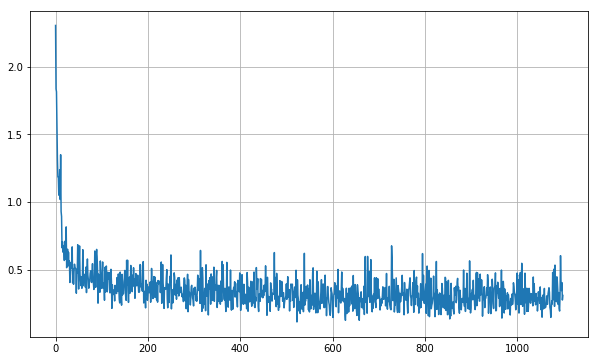

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(losses)
ax.grid(True)

In [16]:
_accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.test.images,
                                          Y_placeholder : mnist.test.labels
                                         })

print(str(round(100*_accuracy,2))+'%')

92.0%
